In [2]:
from mdm import datas
from sklearn.model_selection import RandomizedSearchCV as _rnd_search
from scipy.stats import uniform as _unif
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as _np
from sklearn.metrics import accuracy_score as _acc
import os as _os
import pickle as _pkl
import logging as _log
import seaborn as sns
from sklearn.metrics import confusion_matrix as _cm
from matplotlib import pyplot as _plt
_logger = _log.getLogger(__name__)
_logger.setLevel(_log.INFO)
sns.set()

In [3]:
raw_data = datas.get("../data/", "dataset.csv")

In [4]:
data = datas.transform(raw_data)

2021-05-14 05:31:11,931 | INFO : log volume
2021-05-14 05:31:11,940 | INFO : log density
2021-05-14 05:31:11,943 | INFO : log weight


In [5]:
X_train, y_train, X_dev, y_dev, X_test, y_test = datas.split(data, 'activity',  pct_test=0.2)

2021-05-14 05:31:12,976 | INFO : train size : 720
2021-05-14 05:31:12,977 | INFO : dev size : 90
2021-05-14 05:31:12,977 | INFO : test size : 90


In [29]:
distributions = {'n_estimators':range(2, 150, 1),
        'min_samples_leaf':range(2, 50, 1),
        'max_features':range(2, len(data.columns), 1),
        'max_samples':range(2, 50, 1)
       }
rf = RandomForestClassifier()
clf_rf = _rnd_search(rf, distributions, random_state=0, n_iter=100, n_jobs=-1)
search_rf = clf_rf.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

0.7861111111111111
{'n_estimators': 93, 'min_samples_leaf': 3, 'max_samples': 45, 'max_features': 2}


In [62]:
distributions = {'n_estimators' : range(2, 300, 1),
        'min_samples_leaf' : range(2, 50, 1),
        'max_features' : range(2, len(data.columns), 1),
        'learning_rate' : [1.0 * 10 ** -i for i in range(7)],
        'max_depth' : range(2, 20, 1)
       }
gb = GradientBoostingClassifier()
clf_gb = _rnd_search(gb, distributions, random_state=0, n_iter=200, n_jobs=-1, cv=4)
search_gb = clf_gb.fit(X_train, y_train)
print(search_gb.best_score_)
print(search_gb.best_params_)

0.8222222222222223
{'n_estimators': 73, 'min_samples_leaf': 6, 'max_features': 4, 'max_depth': 6, 'learning_rate': 0.1}


In [65]:
search_gb.best_estimator_

GradientBoostingClassifier(max_depth=6, max_features=4, min_samples_leaf=6,
                           n_estimators=73)

In [170]:
def save(model, path, name):
    if not _os.path.exists(_os.path.join(path, name)):
        _os.makedirs(_os.path.join(path, name))
    _pkl.dump(model, open(_os.path.join(path, name, 'model.pkl'), 'wb'))
    _logger.info("saved to : {0}".format(_os.path.join(path, name)))
    
def load(path, name):
    model = _pkl.load(open(_os.path.join(path, name, 'model.pkl'), 'rb'))
    _logger.info("loaded from : {0}".format(_os.path.join(path, name)))
    return model

def train(mdl, X_train, y_train, X_dev, y_dev):
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_dev)
    acc = _acc(y_dev,y_pred)
    _logger.info("accuracy : {0}".format(acc))
    return acc, mdl

def evaluate(model, X, y):
    y_pred = model.predict(X)
    acc = _acc(y,y_pred)
    _logger.info("accuracy : {0}".format(acc))
    return acc

def predict(model, X):
    y_pred = model.predict(X)
    return y_pred

def confusion_matrix(y_true, y_preds, labels, save_path=None):
    rst = _cm(y_true, y_preds, normalize='true', labels=labels)
    palette = sns.diverging_palette(20, 220, as_cmap=True)
    _plt.figure(figsize=(10,5))
    sns.heatmap(rst, xticklabels=labels, yticklabels=labels, cmap=palette, annot=True)
    if save_path:
        sp = _os.path.join(save_path, 'confusion_matrix.png')
        _logger.info("saving to : {0}".format(sp))
        _plt.savefig(sp, dpi=400)
        
def feature_importance(feat_imp, feats, save_path=None):
    feature_importance = 100.0 * (feat_imp / feat_imp.max())
    sorted_idx = _np.argsort(feat_imp)
    pos = _np.arange(sorted_idx.shape[0]) + .5
    # plt.subplot(1, 2, 2)
    _plt.figure(figsize=(8, 18))
    _plt.barh(pos, feat_imp[sorted_idx], align='center')
    _plt.yticks(pos, feats[sorted_idx])
    _plt.title('Feature Importance')
    if save_path:
        sp = _os.path.join(save_path, 'feature_importance.png')
        _logger.info("saving to : {0}".format(sp))
        _plt.savefig(sp, dpi=400)
    _plt.show()

In [154]:
models_path = '.'
model_name = 'gb_v1'

In [155]:
save(search_gb.best_estimator_, models_path, model_name)

2021-05-14 01:38:27,709 | INFO : saved to : ./gb_v1


In [156]:
model = load(models_path, model_name)

2021-05-14 01:38:28,420 | INFO : loaded from : ./gb_v1


In [79]:
mdl = GradientBoostingClassifier(max_depth=6, max_features=4, min_samples_leaf=6,
                           n_estimators=73)
acc, model = train(mdl, X_train, y_train, X_dev.append(X_test), y_dev.append(y_test))

2021-05-14 01:06:20,076 | INFO : accuracy : 0.8111111111111111


In [140]:
val = evaluate(search_gb.best_estimator_, X_dev.append(X_test), y_dev.append(y_test))

2021-05-14 01:24:01,960 | INFO : accuracy : 0.8111111111111111


In [141]:
preds = predict(model, X_dev.append(X_test))

In [142]:
test_set = X_dev.append(X_test)
test_set['preds'] = preds
test_set['activity'] = y_dev.append(y_test)

2021-05-14 01:41:06,567 | INFO : saving to : ./gb_v1/confusion_matrix.png


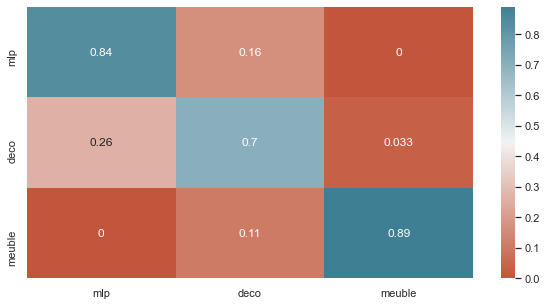

In [164]:
labels = ['mlp', 'deco', 'meuble']
confusion_matrix(test_set.activity, test_set.preds, labels, save_path=_os.path.join(models_path, model_name))

2021-05-14 01:42:22,261 | INFO : saving to : ./gb_v1/feature_importance.png


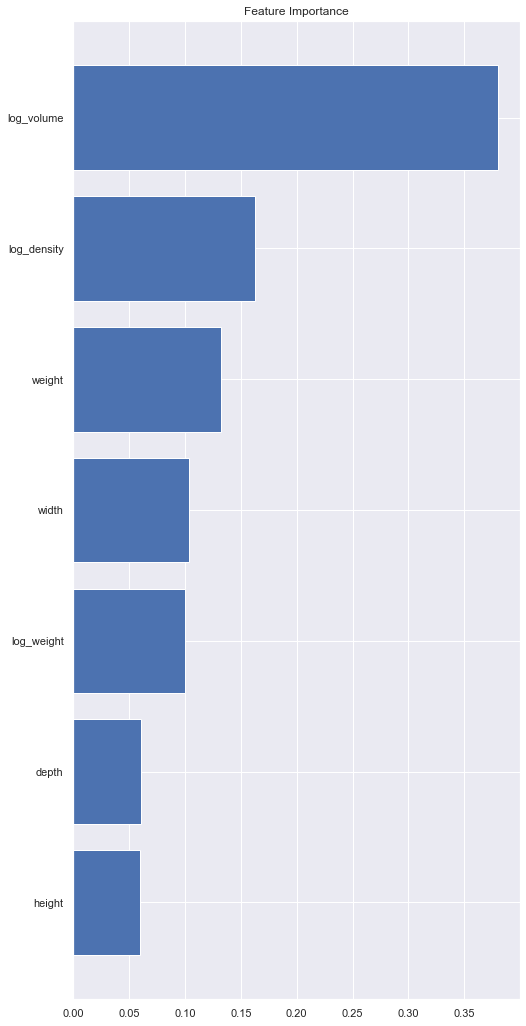

In [169]:
feats = X_train.columns
feature_importance(model.feature_importances_, feats, save_path=_os.path.join(models_path, model_name))